In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Tuple, Optional
import copy
from datasets import load_dataset
from PIL import Image
import random

In [2]:
SEED = 69
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(device)

mps


First we just load and visualize the data from FEMNIST

In [3]:
dataset = load_dataset("flwrlabs/femnist")

DatasetDict({
    train: Dataset({
        features: ['image', 'writer_id', 'hsf_id', 'character'],
        num_rows: 814277
    })
})
We have 814277 data samples.
The keys of dictionary are-
 dict_keys(['image', 'writer_id', 'hsf_id', 'character'])


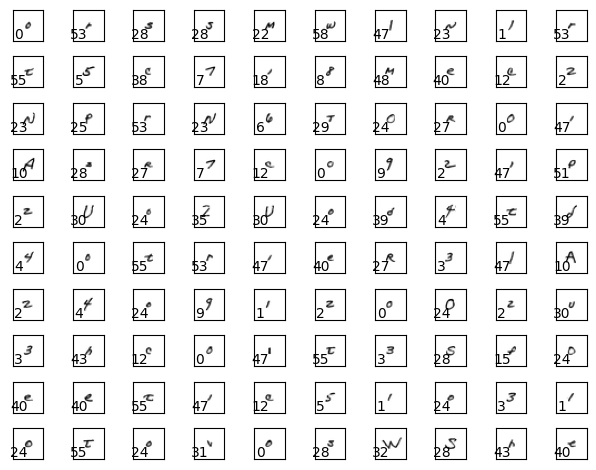

In [4]:
print(dataset)
print(60*"=")
train_ds = dataset["train"]
print(f"We have {len(train_ds)} data samples.")
example = train_ds[0]
fig,axs=plt.subplots(10,10, tight_layout = True)
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(train_ds[i*10+j]["image"], cmap='gray')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].text(0.2, 0.2, train_ds[i*10+j]["character"], horizontalalignment='center', verticalalignment='center', transform=axs[i,j].transAxes)
print("The keys of dictionary are-\n",example.keys())           

In [5]:
split = train_ds.train_test_split(test_size=0.2, seed=42)

train_data = split["train"]
test_data = split["test"]  

print(f"Samples in train - {len(train_data)}, Samples in test - {len(test_data)}")

Samples in train - 651421, Samples in test - 162856


<h3> Task1</h3>
Now the task is to give the training samples to each client<br>
We will do this by partitioning the data using a dirichlet prior<br>
Dirichlet acts like a prior over <b>class proportions per client.</b>



In [6]:
num_classes = len(train_data.features["character"].names)
num_clients = 10
print(num_classes, num_clients)

labels = np.array(train_data["character"])

62 10


In [7]:
alpha = 0.5 #larger value promotes uniform distribution smaller alpha means skewed distribution

# Grouping indices with the same class together
indices_by_class=[np.where(labels==i)[0] for i in range(num_classes)]

# client_data[c][i] = indices for class c assigned to client i
client_data = dict()
print("Number of data samples per class")
for i in range(num_classes):
    print(f"{i}->{len(indices_by_class[i])}")
# print([len(x) for x in indices_by_class])

print("Distribution of classes per client")
for c in range(num_classes):
    client_data[c]=[]
    samples_in_class = indices_by_class[c]
    num_samples_in_class = len(samples_in_class)
    if num_samples_in_class == 0:
        continue

    # Dirichlet proportions for this class across clients
    p = np.random.dirichlet(alpha * np.ones(num_clients))

    # Integer client counts
    counts = np.random.multinomial(num_samples_in_class, p)
    prev=0
    for i in range(num_clients):
        client_data[c].append(indices_by_class[c][prev:prev+counts[i]])
        prev+=counts[i]
    # # OPTIONAL: Print summary
    print(f"Class {c}: {[chunk.shape[0] for chunk in client_data[c]]}")



Number of data samples per class
0->32348
1->35663
2->32257
3->32984
4->31390
5->29288
6->31999
7->33502
8->31758
9->31602
10->5924
11->3605
12->9424
13->4280
14->4632
15->8508
16->2358
17->2964
18->11161
19->3498
20->2289
21->4689
22->8457
23->7656
24->23210
25->7798
26->2388
27->4698
28->19271
29->9100
30->11630
31->4413
32->4371
33->2530
34->4416
35->2477
36->9382
37->4785
38->2621
39->9558
40->22967
41->2365
42->3445
43->8113
44->2536
45->1795
46->2350
47->14255
48->2491
49->10730
50->2595
51->2245
52->2809
53->13105
54->2494
55->16947
56->2694
57->2701
58->2567
59->2611
60->2200
61->2522
Distribution of classes per client
Class 0: [998, 1396, 3736, 128, 6060, 7688, 60, 7852, 1222, 3208]
Class 1: [1080, 177, 227, 7, 328, 11221, 18312, 822, 2470, 1019]
Class 2: [5491, 2663, 1339, 31, 0, 146, 7275, 4025, 5043, 6244]
Class 3: [16849, 990, 7460, 35, 8, 899, 888, 862, 3370, 1623]
Class 4: [1046, 7319, 317, 16644, 3415, 193, 1587, 145, 3, 721]
Class 5: [137, 6338, 1393, 2699, 4789, 4146,

In [8]:
print("Per class label distribution across clients plots")

for c in range(num_classes):
    assert (c in client_data)
    chunks = client_data[c]  # list of indice arrays for class c for each client
    
    counts = np.array([len(chunk) for chunk in chunks], dtype=int)
    total = counts.sum()
    assert(total==indices_by_class[c].shape[0])

    print(
        f"Class{c:2d} |Total={total:5d} |"
        f"min={counts.min():4d} |max={counts.max():6d} |"
        f"mean={counts.mean():7.2f} |std={counts.std():8.2f} |"
    )


Per class label distribution across clients plots
Class 0 |Total=32348 |min=  60 |max=  7852 |mean=3234.80 |std= 2855.71 |
Class 1 |Total=35663 |min=   7 |max= 18312 |mean=3566.30 |std= 5858.56 |
Class 2 |Total=32257 |min=   0 |max=  7275 |mean=3225.70 |std= 2618.25 |
Class 3 |Total=32984 |min=   8 |max= 16849 |mean=3298.40 |std= 4980.54 |
Class 4 |Total=31390 |min=   3 |max= 16644 |mean=3139.00 |std= 4980.07 |
Class 5 |Total=29288 |min=   8 |max=  6338 |mean=2928.80 |std= 2004.70 |
Class 6 |Total=31999 |min=   1 |max= 13630 |mean=3199.90 |std= 4069.10 |
Class 7 |Total=33502 |min=  20 |max= 10980 |mean=3350.20 |std= 3433.76 |
Class 8 |Total=31758 |min=  16 |max= 11300 |mean=3175.80 |std= 3116.67 |
Class 9 |Total=31602 |min=   4 |max=  6828 |mean=3160.20 |std= 2760.76 |
Class10 |Total= 5924 |min=  34 |max=  1705 |mean= 592.40 |std=  559.18 |
Class11 |Total= 3605 |min=   0 |max=  1197 |mean= 360.50 |std=  342.80 |
Class12 |Total= 9424 |min=   0 |max=  6272 |mean= 942.40 |std= 1863.34 |
C

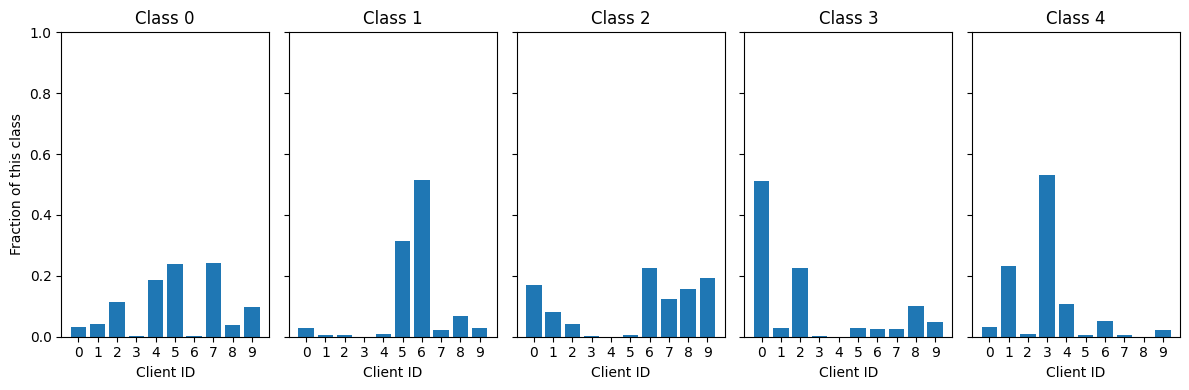

In [20]:
counts_list = []
classes_to_plot=list(range(5))
for c in range(5):
    per_client_data = client_data[c]
    counts_list.append(np.array([len(client) for client in per_client_data]))
    
fig, axes = plt.subplots(1, 5, figsize=(6 * n_plot, 4), sharey=True)
if n_plot == 1:
    axes = [axes]

for ax, c, counts in zip(axes, classes_to_plot, counts_list):
    frac = counts / sum(counts) 
    ax.bar(np.arange(len(frac)), frac)
    ax.set_title(f"Class {c}")
    ax.set_xlabel("Client ID")
    ax.set_xticks(np.arange(len(frac)))
    ax.set_ylim(0, 1.0)                   # same y-axis for all

axes[0].set_ylabel("Fraction of this class")
plt.tight_layout()
plt.show()


In [10]:
class FemnistCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # Input: (N, 1, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, stride=2)  # halves H and W
        self.dropout2d = nn.Dropout2d(p=0.25)

        # After two pools: 28 -> 14 -> 7, channels = 64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, num_classes)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    
    def forward(self, x):
        # x: (N, 1, 28, 28)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)       # (N, 32, 14, 14)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)       # (N, 64, 7, 7)
        x = self.dropout2d(x)

        x = torch.flatten(x, 1)  # (N, 64*7*7)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)          # (N, num_classes)
        return x
    
model = FemnistCNN(num_classes).to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
test_input = torch.randn(4, 1, 28, 28).to(device)
test_output = model(test_input)

print(f"\nTest input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")

assert(test_output.shape==(4,num_classes))

FemnistCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2d): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=62, bias=True)
)

Total parameters: 428,350
Trainable parameters: 428,350

Test input shape: torch.Size([4, 1, 28, 28])
Test output shape: torch.Size([4, 62])


In [12]:
# Build per-client index lists from the per-class Dirichlet splits (client_data)

client_indices = [np.hstack([client_data[i][j] for i in range(num_classes)]) for j in range(num_clients)]

#Shuffle indices within each client for randomness
for cid in range(num_clients):
    np.random.shuffle(client_indices[cid])

# Sanity check
assigned = [len(idxs) for idxs in client_indices]
print("Distribution of data samples per client is", assigned)
print(f"Total samples assigned to clients: {sum(assigned)}")
print(f"Train set size: {len(train_data)}")

assert(sum(assigned)==len(train_data))
print(np.asarray(train_data[0]["image"]).shape)

Distribution of data samples per client is [58361, 77198, 47478, 83471, 67485, 65877, 72134, 68050, 57692, 53675]
Total samples assigned to clients: 651421
Train set size: 651421
(28, 28)


In [42]:
transform = transforms.Compose([
    transforms.Grayscale(),   
    transforms.ToTensor(),  
])

class Custom_Dataset(Dataset):
    def __init__(self, dataset, indices, transform=transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        item = self.dataset[self.indices[idx]]
        img = item["image"]       # PIL image
        label = item["character"]
        if self.transform is not None:
            img = self.transform(img)  # -> (1, 28, 28) tensor
        return (img, label)

class client():
    def __init__(self,client_id:int,dataset:Custom_Dataset, model:FemnistCNN, optimizer:str, lr:float):
        self.client_id=client_id
        self.dataset=dataset
        self.dataloader=DataLoader(self.dataset, batch_size=64, shuffle=True)
        self.model=model
        self.lr=lr
        self.name=optimizer.lower()
        self.optimizer=self._get_optimizer(optimizer.lower())
        self.losses=[]
        self.fedprox=False
        self.u=1
        
    def _get_optimizer(self, name):
        params=self.model.parameters()
        if name=="sgd":
            return optim.SGD(params, lr=self.lr)
        elif name == "sgd_momentum":
            return optim.SGD(params, lr=self.lr, momentum=0.9, nesterov=False)
        elif name == "adam":
            return optim.Adam(params)
        elif name == "adamw":
            return optim.AdamW(params)
        elif name == "rmsprop":
            return optim.RMSprop(params)
        elif name == "radam":
            return optim.RAdam(params)
        elif name=="nadam":
            return optim.NAdam(params)
        elif name=="fedprox":
            self.fedprox=True
            return optim.SGD(params, lr=self.lr)
        else:
            raise ValueError(f"Unknown optimizer: {name}")
    def train(self,epochs, status=False):
        # for _ in range(epochs):
        # print(len(self.dataloader))
        i=0
        # items=tqdm(iter(self.dataloader), ", leave=False )
        w_ = {name: param.clone() for name, param in self.model.state_dict().items()}
        self.model.train()
        for x,y in iter(self.dataloader):
            i+=1
            if (status and (i%50==0)):
                print(f"Client {self.client_id} | Epoch {i}/{epochs}")
            outputs=self.model(x)
            loss=torch.nn.CrossEntropyLoss()(outputs,y)
            if (self.fedprox):
                for name,param in w_.items():
                    loss+=self.u*((param-self.model.state_dict()[name])**2).sum()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
            if i==epochs:
                break

    def send_to_server(self):
        state = {name: param.clone() for name, param in self.model.state_dict().items()}
        n = len(self.dataset)
        return (state,n)

    def receive_from_server(self, param_dict):
        state={name: param.clone() for name, param in param_dict.items()}
        self.model.load_state_dict(state)

    def set_learning_rate(self, lr):
        self.optimizer.lr=lr
class server():
    def __init__(self, clients:[client], dataset:Custom_Dataset, model, optimizer:str, lr:float):
        self.clients=clients
        self.optimizer=optimizer
        self.model=model
        self.dataset=dataset
        self.dataloader=DataLoader(self.dataset, batch_size=128, shuffle=True)
        self.X=None
        self.Y=None
        self.lr=lr
        self.losses=[]
        self.predictions_correct=[]
        self.local_rounds=100
        self.path=f"./model_{self.clients[0].name}.pt"
        
    def global_round(self):
        for client in self.clients:
            client.receive_from_server(self.model.state_dict())   
        #put here random indices for client sampling
        for client in self.clients:
            client.train(self.local_rounds,True) #number of epochs

        client_weights=[]
        for client in self.clients:
            client_weights.append(client.send_to_server())

        if self.optimizer=="SGD":
            new_weight_dict={k:torch.zeros_like(v) for k,v in client_weights[0][0].items()}
            for i in range(len(client_weights)):
                client_dict=client_weights[i][0]
                client_samples=client_weights[i][1]
                for k,v in client_dict.items():
                    new_weight_dict[k]+=v*client_samples/len(self.dataset)
            self.model.load_state_dict(new_weight_dict)
            
    def train(self, rounds):
        for i in range(rounds):
            print(f"Running round {i+1}/{rounds} on server.")
            self.global_round()
            self.evaluate(500)
            print(f"Loss:{self.losses[-1]}, Accuracy: {self.predictions_correct[-1]*100}%")
        self.evaluate(len(self.dataset)//128+1)
        print(f"Final Loss:{self.losses[-1]}, Accuracy: {self.predictions_correct[-1]*100}%")
    def evaluate(self,batches):
        self.model.eval()
        loss=0
        correct=0
        total=0
        i=0
        for x,y in iter(self.dataloader):
            i+=1
            outputs=self.model(x)
            loss_=torch.nn.CrossEntropyLoss()(outputs,y)
            loss+=loss_.item()
            correct+=(outputs.argmax(axis=1)==y).sum()
            total+=y.shape[0]
            if (i==batches):
                break
        self.losses.append(loss)
        self.predictions_correct.append(correct/total)

    def save_state(self):
        torch.save(self.model.state_dict(), self.path)

    def load_state(self):
        self.model.load_state_dict(torch.load(self.path, weights_only=True))
        

In [43]:
clients=[client(i+1,Custom_Dataset(train_data,client_indices[i]),FemnistCNN(num_classes),"fedprox",0.001) for i in range(num_clients)]
myServer=server(clients,Custom_Dataset(train_data,list(range(len(train_data)))),FemnistCNN(num_classes),"SGD",0.001)

In [ ]:
try:
    myServer.load_state()
    myServer.train(1000)
except:
    myServer.save_state()

Running round 1/1000 on server.
Client 1 | Epoch 50/100
Client 1 | Epoch 100/100
Client 2 | Epoch 50/100
Client 2 | Epoch 100/100
Client 3 | Epoch 50/100
Client 3 | Epoch 100/100
Client 4 | Epoch 50/100
Client 4 | Epoch 100/100
Client 5 | Epoch 50/100
Client 5 | Epoch 100/100
Client 6 | Epoch 50/100
Client 6 | Epoch 100/100
Client 7 | Epoch 50/100
Client 7 | Epoch 100/100
Client 8 | Epoch 50/100
Client 8 | Epoch 100/100
Client 9 | Epoch 50/100
Client 9 | Epoch 100/100
Client 10 | Epoch 50/100
Client 10 | Epoch 100/100
Loss:1902.2618174552917, Accuracy: 6.920312404632568%
Running round 2/1000 on server.
Client 1 | Epoch 50/100
Client 1 | Epoch 100/100
Client 2 | Epoch 50/100
Client 2 | Epoch 100/100
Client 3 | Epoch 50/100
Client 3 | Epoch 100/100
Client 4 | Epoch 50/100
Client 4 | Epoch 100/100
Client 5 | Epoch 50/100
Client 5 | Epoch 100/100
Client 6 | Epoch 50/100
Client 6 | Epoch 100/100
Client 7 | Epoch 50/100
Client 7 | Epoch 100/100
Client 8 | Epoch 50/100
Client 8 | Epoch 100/10

In [41]:
myServer.save_state()

In [ ]:
# %% [code]
import pandas as pd
import matplotlib.pyplot as plt

results_csv = "fedavg_results_with_trainloss.csv"
df = pd.read_csv(results_csv)

rounds = df["round"]

# --- Training Loss vs Rounds ---
plt.figure(figsize=(6,4))
plt.plot(rounds, df["train_loss"], linewidth=2)
plt.title("Training Loss vs Rounds")
plt.xlabel("Round")
plt.ylabel("Training Loss")
plt.grid(True)
plt.show()

# --- Test Loss vs Rounds ---
plt.figure(figsize=(6,4))
plt.plot(rounds, df["global_loss"], linewidth=2)
plt.title("Test Loss vs Rounds")
plt.xlabel("Round")
plt.ylabel("Test Loss")
plt.grid(True)
plt.show()

# --- Test Accuracy vs Rounds ---
plt.figure(figsize=(6,4))
plt.plot(rounds, df["global_acc"], linewidth=2)
plt.title("Test Accuracy vs Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()